# Setup

Skip the next cell if you're not running this on Colab.

In [ ]:
# Colab setup
! git clone https://github.com/biomedia-mira/deepscm.git
! pip install -r deepscm/requirements.txt
%cd deepscm/deepscm/experiments/plotting/ukbb/

In [1]:
%matplotlib inline

from plotting_helper import plot_gen_intervention_range, interactive_plot

# Plotting

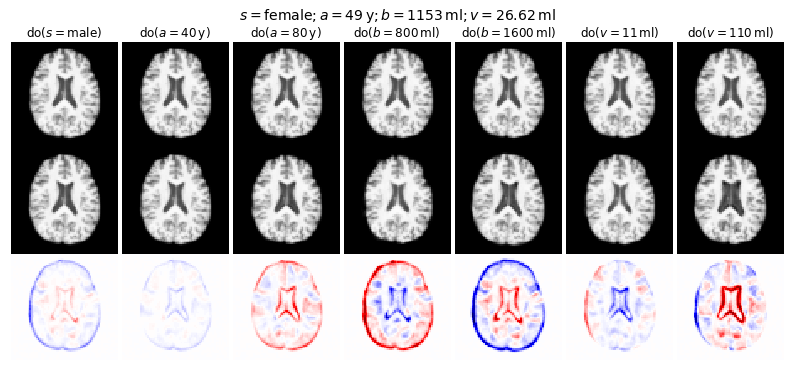

In [2]:
idx = 0
model_name = 'ConditionalVISEM'

interventions = [
    {'sex': 1.},
    {'age': 40.},
    {'age': 80.},
    {'brain_volume': 800000.},
    {'brain_volume': 1600000.},
    {'ventricle_volume': 11000.},
    {'ventricle_volume': 110000.},
]

plot_gen_intervention_range(model_name, interventions, idx, normalise_all=True, num_samples=32)

# Interactive Plotting

In [3]:
interactive_plot(model_name)